Using device: cpu
Epoch 0, PDE loss=4.6628e-03, BC loss=1.2620e-02, total=1.7282e-02
Epoch 500, PDE loss=8.9895e-07, BC loss=2.3242e-07, total=1.1314e-06
Epoch 1000, PDE loss=2.2069e-07, BC loss=6.9821e-08, total=2.9051e-07
Epoch 1500, PDE loss=6.7687e-08, BC loss=1.9489e-07, total=2.6257e-07
Epoch 2000, PDE loss=3.2996e-08, BC loss=1.8705e-08, total=5.1702e-08
Epoch 2500, PDE loss=3.7295e-07, BC loss=5.0390e-06, total=5.4119e-06
Epoch 3000, PDE loss=1.5901e-08, BC loss=9.4948e-09, total=2.5396e-08
Epoch 3500, PDE loss=1.3173e-08, BC loss=8.0016e-09, total=2.1174e-08
Epoch 4000, PDE loss=5.3488e-08, BC loss=1.3215e-07, total=1.8564e-07
Epoch 4500, PDE loss=2.4602e-08, BC loss=2.9965e-07, total=3.2425e-07

Training complete.



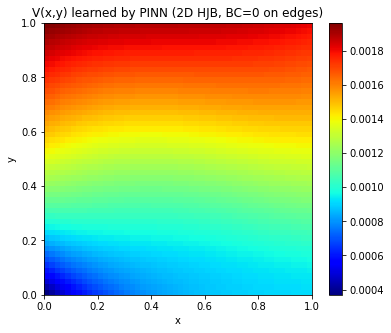

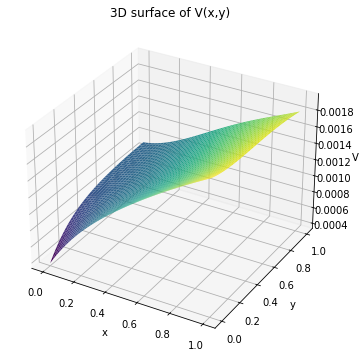

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
2D HJB Example with Continuous Control in [-1,1]

PDE:
  -r * V(x,y)
  + max_{a in [-1,1]} [ (x+a)* V_x + (y+a)* V_y - alpha*a^2 ] = 0
  for (x,y) in (0,1)x(0,1),

Boundary condition:  V=0 on all edges:
   (x=0 or x=1 or y=0 or y=1).

Interpretation:
  r>0 is discount rate,
  alpha>0 is penalty on control^2.
  We define a*(x,y) by unconstrained optimum
   a_unclamped= (V_x + V_y)/(2 alpha),
  then clamp to [-1,1].

PINN approach:
  - We define a neural network V(x,y).
  - PDE residual is computed at random interior collocation points.
  - Boundary condition is enforced by a penalty MSE(V(boundary)-0).

We log PDE loss, BC loss, total loss each iteration, then display
the final learned V(x,y) in a 2D colormap and a 3D surface plot.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # for 3D surface plots

# -------------------- PDE/Control Parameters --------------------
r = 0.05
alpha = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------- Neural Network --------------------
class HJB2DNet(nn.Module):
    """
    A feed-forward network for V(x,y).
    Inputs: (x,y), each in [0,1].
    Output: scalar V(x,y).
    """
    def __init__(self, hidden_units=64):
        super(HJB2DNet, self).__init__()
        self.layer1 = nn.Linear(2, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.activation = nn.Tanh()

    def forward(self, xy):
        # xy shape: (N,2), columns [x,y]
        out = self.activation(self.layer1(xy))
        out = self.activation(self.layer2(out))
        out = self.layer3(out)
        return out

# -------------------- PDE Residual Function --------------------
def hjb_2d_residual(model, x, y):
    """
    PDE:
      -r V + max_{a in [-1,1]} [ (x+a)*Vx + (y+a)*Vy - alpha a^2 ] = 0.

    We do:
      a_unclamped = (Vx + Vy)/(2 alpha),
      a_star = clamp(a_unclamped, -1, 1).

    Then residual = -r V + (x+a_star)*Vx + (y+a_star)*Vy - alpha(a_star)^2.

    Args:
      model: The neural net for V(x,y).
      x,y: Tensors shape (N,1) in the interior domain.

    Returns:
      residual shape (N,1).
    """
    x.requires_grad_(True)
    y.requires_grad_(True)

    XY = torch.cat([x, y], dim=1)  # shape (N,2)
    V = model(XY)  # shape (N,1)

    # partial derivatives
    Vx = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V),
                             create_graph=True)[0]
    Vy = torch.autograd.grad(V, y, grad_outputs=torch.ones_like(V),
                             create_graph=True)[0]

    # unconstrained optimum
    a_unclamped = (Vx + Vy)/(2*alpha)
    a_star = torch.clamp(a_unclamped, -1.0, 1.0)

    # PDE expression
    expr = (x + a_star)*Vx + (y + a_star)*Vy - alpha*(a_star**2)
    residual = -r*V + expr
    return residual

# -------------------- Sampling Utilities --------------------
def sample_interior(N):
    """
    Return random points (x,y) in (0,1)x(0,1).
    shape: (N,1) each.
    """
    x = torch.rand((N,1), device=device)
    y = torch.rand((N,1), device=device)
    return x, y

def sample_boundary(N):
    """
    Return points on boundary of the unit square.
    We'll sample N points for each edge -> total 4N points.
    shape: (4N,2).
    BC: V=0 on boundary.
    """
    x_rand = torch.rand((N,1), device=device)
    y_rand = torch.rand((N,1), device=device)

    # top    y=1
    top = torch.cat([x_rand, torch.ones_like(x_rand)], dim=1)
    # bottom y=0
    bottom = torch.cat([x_rand, torch.zeros_like(x_rand)], dim=1)
    # left   x=0
    left = torch.cat([torch.zeros_like(y_rand), y_rand], dim=1)
    # right  x=1
    right = torch.cat([torch.ones_like(y_rand), y_rand], dim=1)

    boundary = torch.cat([top, bottom, left, right], dim=0)  # shape (4N,2)
    return boundary

# -------------------- Main --------------------
def main():
    # Hyperparams
    hidden_units = 64
    lr = 1e-3
    num_epochs = 5000
    N_interior = 2000
    N_boundary = 400

    model = HJB2DNet(hidden_units=hidden_units).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 1) PDE residual inside domain
        x_in, y_in = sample_interior(N_interior)
        res_in = hjb_2d_residual(model, x_in, y_in)
        loss_pde = torch.mean(res_in**2)

        # 2) Boundary condition => V=0
        boundary_xy = sample_boundary(N_boundary)  # shape (4N,2)
        V_bdy = model(boundary_xy)
        loss_bc = torch.mean(V_bdy**2)

        # total loss
        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()

        # log every 500 epochs
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, PDE loss={loss_pde.item():.4e}, BC loss={loss_bc.item():.4e}, total={loss.item():.4e}")

    print("\nTraining complete.\n")

    # Evaluate on a grid for visualization
    Nx, Ny = 50, 50
    x_lin = torch.linspace(0,1,Nx, device=device)
    y_lin = torch.linspace(0,1,Ny, device=device)
    XX, YY = torch.meshgrid(x_lin, y_lin, indexing='xy')
    # Flatten for model input
    XY_flat = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)
    model.eval()
    with torch.no_grad():
        V_pred = model(XY_flat).cpu().numpy().reshape(Nx, Ny)

    # Plot 2D colormap
    plt.figure(figsize=(6,5))
    plt.imshow(
        V_pred.T,  # note the transpose so x is horizontal axis
        origin='lower',
        extent=[0,1,0,1],
        aspect='auto',
        cmap='jet'
    )
    plt.colorbar()
    plt.title("V(x,y) learned by PINN (2D HJB, BC=0 on edges)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    # 3D surface plot
    X_np = XX.cpu().numpy()
    Y_np = YY.cpu().numpy()
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_np, Y_np, V_pred, cmap='viridis')
    ax.set_title("3D surface of V(x,y)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("V")
    plt.show()

if __name__ == "__main__":
    main()
